# Iteratively block configurations

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#from operator import xor
#from blocks import Blocks
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
from iterated_blocking import *
#from count_bonds import *
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox
from scipy.signal import find_peaks_cwt

%autoreload 2
%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))    # critical temperature

## Iteratively Block L = 32 configs

In [4]:
config_dir32 = '../data/configs/32_lattice/separated_data/'
configs32 = sorted([
    config_dir32 + i for i in os.listdir(config_dir32) if i.endswith('.txt')
])
for file in configs32:
    block_configs(file)

Reading from ../data/configs/32_lattice/separated_data/32_config_1.0.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.0.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.1.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_1.2.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.2.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_1.3.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.3.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_1.4.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.4.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.5.txt

Reading from ../data/configs/32_lattice/

Reading from ../data/configs/32_lattice/separated_data/32_config_3.1.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.1.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_3.2.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.2.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_3.3.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.3.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_3.4.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.4.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_3.5.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.5.txt

Reading from ../data/configs/32_lattice/separated_data/32_config_3.6.txt
Saving to: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.6.txt

Reading from ../data/configs/32_lattice/

In [5]:
config_dir32_b16 = '../data/iterated_blocking/32_lattice/blocked_16/'
configs32_b16 = sorted([
    config_dir32_b16 + i for i in os.listdir(config_dir32_b16) if
    i.endswith('.txt')
])
for file in configs32_b16:
    block_configs(file)

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.0.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.0.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.1.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.1.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.2.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.2.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.3.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.3.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.4.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.4.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.5.txt
Saving to: ../data/iterated_blocking/16_lattice

Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_2.75.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_2.8.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_2.8.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_2.9.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_2.9.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.0.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_3.0.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.1.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_3.1.txt

Reading from ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_3.2.txt
Saving to: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_3.2.txt

Reading from ../data/iterated_blocking/32_lattice

In [6]:
config_dir16_b8 = '../data/iterated_blocking/16_lattice/blocked_8/'
configs16_b8 = sorted([
    config_dir16_b8 + i for i in os.listdir(config_dir16_b8) if
    i.endswith('.txt')
])
for file in configs16_b8:
    block_configs(file)

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.0.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.0.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.1.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.1.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.2.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.2.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.3.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.3.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.4.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.4.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.5.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_block

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_2.8.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_2.8.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_2.9.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_2.9.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_3.0.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_3.0.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_3.1.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_3.1.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_3.2.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_3.2.txt

Reading from ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_3.3.txt
Saving to: ../data/iterated_blocking/8_lattice/blocked_4/4_block

In [7]:
config_dir8_b4 = '../data/iterated_blocking/8_lattice/blocked_4/'
configs8_b4 = sorted([
    config_dir8_b4 + i for i in os.listdir(config_dir8_b4) if
    i.endswith('.txt')
])
for file in configs8_b4:
    block_configs(file)

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.0.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.0.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.1.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.1.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.2.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.2.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.3.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.3.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.4.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.4.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.5.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_con

Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_2.8.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_2.9.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_2.9.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_3.0.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_3.0.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_3.1.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_3.1.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_3.2.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_3.2.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_3.3.txt
Saving to: ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_3.3.txt

Reading from ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_co

In [8]:
config_dir4_b2 = '../data/iterated_blocking/4_lattice/blocked_2/'
configs4_b2 = sorted([
    config_dir4_b2 + i for i in os.listdir(config_dir4_b2) if
    i.endswith('.txt')
])
for file in configs4_b2:
    block_configs(file)

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.0.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_1.0.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.1.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_1.1.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.2.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_1.2.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.3.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_1.3.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.4.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_1.4.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_1.5.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_con

Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_2.8.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_2.9.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_2.9.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_3.0.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_3.0.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_3.1.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_3.1.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_3.2.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_3.2.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_configs_3.3.txt
Saving to: ../data/iterated_blocking/2_lattice/blocked_1/1_blocked_configs_3.3.txt

Reading from ../data/iterated_blocking/4_lattice/blocked_2/2_blocked_co

## Run CountBonds on blocked configs

In [9]:
save_dir = (
    '../data/bond_stats/iterated_blocking/{}_lattice/'.format(32)
)
count_bonds32 = CountBonds(32, verbose=True, num_blocks=5, 
                           data_dir=config_dir32, 
                           save_dir=save_dir)
Nb32 = np.array([
    (i[0], i[1]) for i in list(count_bonds32.bond_stats.values())
])
delta_Nb32 = np.array([
    (i[2], i[3]) for i in list(count_bonds32.bond_stats.values())
])
Nb32_temps = np.array([
    float(i) for i in list(count_bonds32.bond_stats.keys())
])
# 14m 9s, num_blocks=2

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.0.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.1.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.2.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.3.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.4.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.6.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.7.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.8.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.85.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.9.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_config_1.95.txt

Reading in from: ../data/configs/32_lattice/separated_data/32_

In [10]:
save_dir = (
    '../data/bond_stats/iterated_blocking/{}_lattice/'.format(16)
)
count_bonds16 = CountBonds(16, verbose=True, num_blocks=5, 
                           data_dir=config_dir32_b16, save_dir=save_dir)
Nb16 = np.array([
    (i[0], i[1]) for i in list(count_bonds16.bond_stats.values())
])
delta_Nb16 = np.array([
    (i[2], i[3]) for i in list(count_bonds16.bond_stats.values())
])
Nb16_temps = np.array([
    float(i) for i in list(count_bonds16.bond_stats.keys())
])
# 3m 26s, num_blocks=2

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.0.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.1.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.2.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.3.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.4.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.5.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.6.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.7.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.8.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_blocked_configs_1.85.txt

Reading in from: ../data/iterated_blocking/32_lattice/blocked_16/16_b

In [11]:
save_dir = (
    '../data/bond_stats/iterated_blocking/{}_lattice/'.format(8)
)
count_bonds8 = CountBonds(8, verbose=True, num_blocks=5,
                           data_dir=config_dir16_b8, save_dir=save_dir)
Nb8 = np.array([
    (i[0], i[1]) for i in list(count_bonds8.bond_stats.values())
])
delta_Nb8 = np.array([
    (i[2], i[3]) for i in list(count_bonds8.bond_stats.values())
])
Nb8_temps = np.array([
    float(i) for i in list(count_bonds8.bond_stats.keys())
])
# 58.9s, num_blocks=2

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.0.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.1.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.2.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.3.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.4.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.5.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.6.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.7.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.8.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.85.txt

Reading in from: ../data/iterated_blocking/16_lattice/blocked_8/8_blocked_configs_1.9.txt

In [12]:
save_dir = (
    '../data/bond_stats/iterated_blocking/{}_lattice/'.format(4)
)
count_bonds4 = CountBonds(4, verbose=True, num_blocks=5,
                           data_dir=config_dir8_b4, save_dir=save_dir)
Nb4 = np.array([
    (i[0], i[1]) for i in list(count_bonds4.bond_stats.values())
])
delta_Nb4 = np.array([
    (i[2], i[3]) for i in list(count_bonds4.bond_stats.values())
])
Nb4_temps = np.array([
    float(i) for i in list(count_bonds4.bond_stats.keys())
])
# 21.4s, num_blocks=2

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.0.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.1.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.2.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.3.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.4.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.5.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.6.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.7.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.8.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.85.txt

Reading in from: ../data/iterated_blocking/8_lattice/blocked_4/4_blocked_configs_1.9.txt

Reading i

## Plot  $\langle \Delta_{N_b}^2\rangle$ vs. $T$

<IPython.core.display.Javascript object>


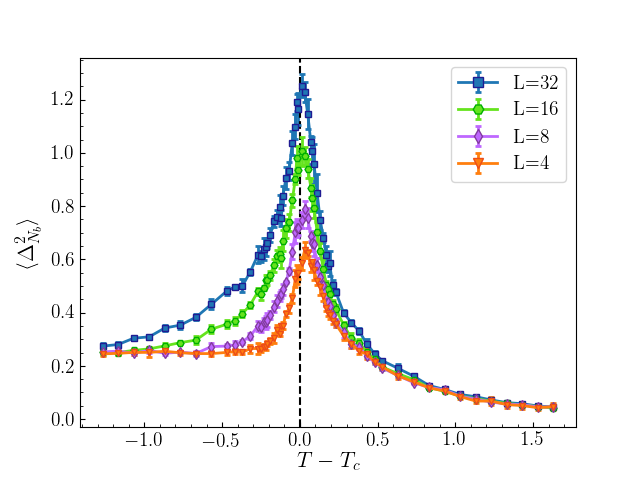

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'$T-T_c$')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle$')

Saving file to: ../plots/iterated_blocking/bond_stats/delta_Nb_all_10.png


In [13]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((Nb32_temps-Tc), delta_Nb32[:,0]/(2*32*32), 
            yerr=delta_Nb32[:,1]/(32*32),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2., capsize=2, capthick=2,
            label='L=32')
ax.errorbar((Nb16_temps-Tc), delta_Nb16[:,0]/(2*16*16), 
            yerr=delta_Nb16[:,1]/(16*16),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb8_temps-Tc), delta_Nb8[:,0]/(2*8*8),
            yerr=delta_Nb8[:,1]/(8*8),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb4_temps-Tc), delta_Nb4[:,0]/(2*4*4), 
            yerr=delta_Nb4[:,1]/(4*4),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(1., 3.5)
ax.set_xlabel('$T-T_c$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
out_dir = '../plots/iterated_blocking/bond_stats/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


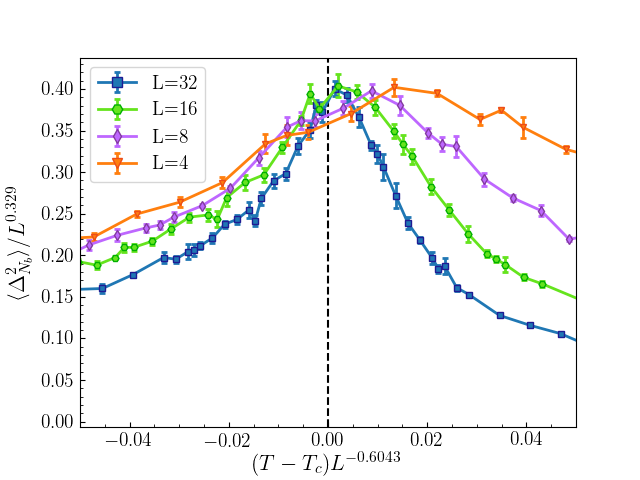

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(-0.05, 0.05)

Text(0.5,0,'$(T-T_c)L^{-0.6043}$')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle/L^{0.329}$')

Saving file to: ../plots/iterated_blocking/bond_stats/collapsed/delta_Nb_all_collapsed_zoomed_14.png


In [51]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((Nb32_temps-Tc)*32**(-0.6043), 
            delta_Nb32[:,0]/(2*32*32*32**(0.329)), 
            yerr=delta_Nb32[:,1]/(2*32*32*32**(1./4)),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2., capsize=2, capthick=2,
            label='L=32')
ax.errorbar((Nb16_temps-Tc)*16**(-0.6043), 
            delta_Nb16[:,0]/(2*16*16*16**(0.329)), 
            yerr=delta_Nb16[:,1]/(2*16*16*16**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb8_temps-Tc)*8**(-0.6043), 
            delta_Nb8[:,0]/(2*8*8*8**(0.329)),
            yerr=delta_Nb8[:,1]/(2*8*8*8**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb4_temps-Tc)*4**(-0.6043),
            delta_Nb4[:,0]/(2*4*4*4**(0.329)), 
            yerr=delta_Nb4[:,1]/(2*4*4*4**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(-0.05, 0.05)
ax.set_xlabel('$(T-T_c)L^{-0.6043}$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle/L^{0.329}$", fontsize=16)
out_dir = '../plots/iterated_blocking/bond_stats/collapsed/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_collapsed_zoomed_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## Peak analysis

### Peak Value

In [44]:
delta_Nb32_peak = np.max(delta_Nb32[:,0]/(2*32*32))
delta_Nb16_peak = np.max(delta_Nb16[:,0]/(2*16*16))
delta_Nb8_peak = np.max(delta_Nb8[:,0]/(2*8*8))
delta_Nb4_peak = np.max(delta_Nb4[:,0]/(2*4*4))

In [45]:
inv_L_arr = np.log(np.array([1./32, 1./16, 1./8, 1./4]))
delta_Nb_peak_arr = np.log(np.array([
    delta_Nb32_peak, delta_Nb16_peak, delta_Nb8_peak, delta_Nb4_peak
]))
m0, b0 = np.polyfit(inv_L_arr, delta_Nb_peak_arr, 1)

In [46]:
fit_x0 = np.linspace(1./32, 1./4, 500)
#fit_x = np.arange(2, 32)
log_y0_fit = b0 + np.log(fit_x0) * m0
fit_y0 = np.exp(log_y0_fit)

<IPython.core.display.Javascript object>


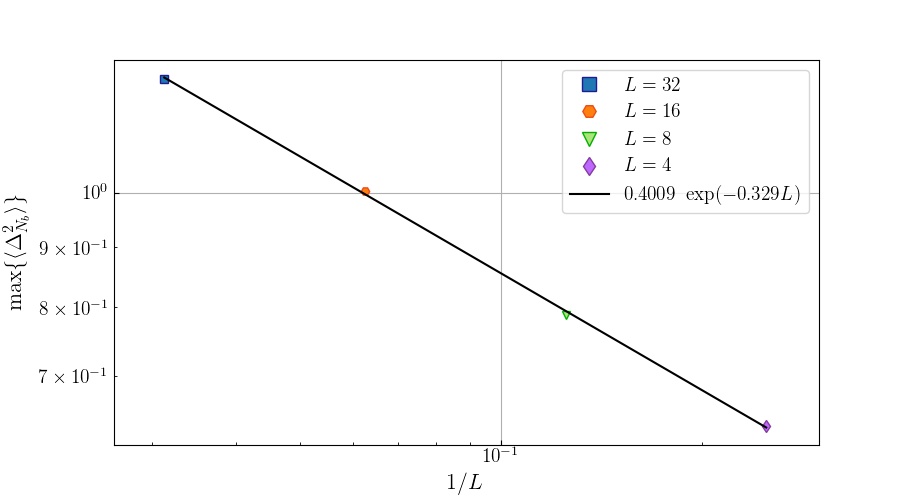

(0.02625, 0.3)

Text(0,0.5,'$\\max\\{\\langle \\Delta_{N_b}^2\\rangle\\}$')

Text(0.5,0,'$1/L$')

Saving file to: ../plots/peak_analysis/iterated_blocking/delta_Nb/delta_Nb_peak_val_6.png


In [47]:
fig, ax = plt.subplots()
ax.loglog(1./32, delta_Nb32_peak,
          marker='s', 
          markeredgecolor='#1f1b93',
          #markersize=5., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.loglog(1./16, delta_Nb16_peak,
          marker='H', 
          color='C1',
          markeredgecolor='#ed4c18',
          #markersize=5, 
          ls='',
          label=r"$L = 16$")
ax.loglog(1./8, delta_Nb8_peak,
          marker='v',
          #markersize=5, 
          color='#ABE479', 
          markeredgecolor='#00B000',
          ls='', 
          label=r"$L = 8$")
ax.loglog(1./4, delta_Nb4_peak,
          marker='d', 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          #markersize=5, 
          ls='',
          label=r"$L=4$")
ax.plot(fit_x0, fit_y0,
        ls='-',
        color='k',
        #label=r"${:.3g}L + {:.5g}$".format(m, b))
        label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b0), m0))
#ax.legend()
ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
plt.ylabel(r"$\max\{\langle \Delta_{N_b}^2\rangle\}$", 
           fontsize=16)
plt.xlabel(r"$1/L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/iterated_blocking/delta_Nb/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'delta_Nb_peak_val_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Peak Position

In [31]:
delta_Nb32_peakT = Nb32_temps[np.argmax(delta_Nb32[:,0]/(2*32*32))] - Tc
delta_Nb16_peakT = Nb16_temps[np.argmax(delta_Nb16[:,0]/(2*16*16))] - Tc
delta_Nb8_peakT = Nb8_temps[np.argmax(delta_Nb8[:,0]/(2*8*8))] - Tc
delta_Nb4_peakT = Nb4_temps[np.argmax(delta_Nb4[:,0]/(2*4*4))] - Tc

In [32]:
L_arr = np.log(np.array([4, 8, 16, 32]))
delta_Nb_peakT_arr = np.log(np.array([
    delta_Nb4_peakT, delta_Nb8_peakT, delta_Nb16_peakT, delta_Nb32_peakT
]))
m1, b1 = np.polyfit(L_arr, delta_Nb_peakT_arr, 1)

In [33]:
fit_x1 = np.linspace(4, 32, 500)
#fit_x = np.arange(2, 32)
log_y1_fit = b1 + np.log(fit_x1) * m1
fit_y1 = np.exp(log_y1_fit)

<IPython.core.display.Javascript object>


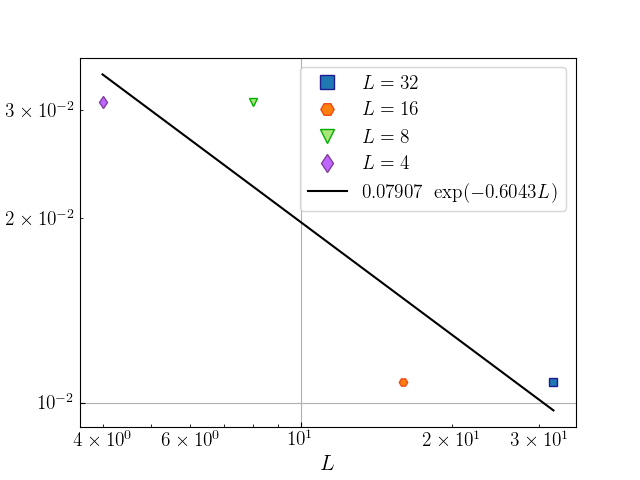

Text(0,0.5,'$(T^{*} - T_c)$')

Text(0.5,0,'$L$')

Saving file to: ../plots/peak_analysis/iterated_blocking/delta_NbT/delta_Nb_peak_pos_1.png


In [34]:
fig, ax = plt.subplots()
ax.loglog(32, delta_Nb32_peakT,
          marker='s', 
          markeredgecolor='#1f1b93',
          #markersize=5., 
          color='C0',
          ls='',
          label=r"$L = 32$")
ax.loglog(16, delta_Nb16_peakT,
          marker='H', 
          color='C1',
          markeredgecolor='#ed4c18',
          #markersize=5, 
          ls='',
          label=r"$L = 16$")
ax.loglog(8, delta_Nb8_peakT,
          marker='v',
          #markersize=5, 
          color='#ABE479', 
          markeredgecolor='#00B000',
          ls='', 
          label=r"$L = 8$")
ax.loglog(4, delta_Nb4_peakT,
          marker='d', 
          color='#be67ff',
          markeredgecolor='#833c9f', 
          #markersize=5, 
          ls='',
          label=r"$L=4$")
ax.plot(fit_x1, fit_y1,
        ls='-',
        color='k',
        #label=r"${:.3g}L + {:.5g}$".format(m, b))
        label=r"${:.4g}\,\,\exp({{{:.4g}L}})$".format(np.exp(b1), m1))
#ax.legend()
#ax.set_xlim(1./32-0.005, 1./4+0.05)
plt.legend(loc='best', fontsize=14, markerscale=1.6)
#plt.title(r"$\log\left(\max\{\langle \Delta_{N_b}^2\rangle\}\right)$ vs. $L$", 
#          fontsize=18)
plt.ylabel(r"$(T^{*} - T_c)$", fontsize=16)
plt.xlabel(r"$L$", fontsize=16)
ax.grid()
out_dir = '../plots/peak_analysis/iterated_blocking/delta_NbT/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'delta_Nb_peak_pos_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()